In [1]:
import os
import requests

# Configuration
folder_name = "Dont_Patronize_Me_Trainingset"
github_raw_base = "https://raw.githubusercontent.com/CRLala/NLPLabs-2024/main/Dont_Patronize_Me_Trainingset/"

# List the specific files you need from that folder
files_to_download = [
    "dontpatronizeme_categories.tsv",
    "dontpatronizeme_pcl.tsv"
]

# 1. Create the directory if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Created directory: {folder_name}")

# 2. Download files only if they are missing
for file_name in files_to_download:
    file_path = os.path.join(folder_name, file_name)
    
    if os.path.exists(file_path):
        print(f"File already exists: {file_name} (Skipping...)")
    else:
        print(f"Downloading {file_name}...")
        url = github_raw_base + file_name
        response = requests.get(url)
        
        if response.status_code == 200:
            with open(file_path, "wb") as f:
                f.write(response.content)
            print(f"Successfully downloaded {file_name}")
        else:
            print(f"Failed to download {file_name}. Status code: {response.status_code}")

print("\nData check complete.")

Created directory: Dont_Patronize_Me_Trainingset
Successfully downloaded dontpatronizeme_categories.tsv
Successfully downloaded dontpatronizeme_pcl.tsv

Data check complete.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re

In [17]:
# Load the dataset
data_path = "Dont_Patronize_Me_Trainingset/dontpatronizeme_pcl.tsv"

df = pd.read_csv(
    data_path,
    sep="\t",
    skiprows=4,   # skip disclaimer
    header=None,
    names=[
        "par_id",
        "art_id",
        "keyword",
        "country_code",
        "text",
        "label"
    ],
    engine="python"
)

df.head()

,par_id,art_id,keyword,country_code,text,label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0
2,3,@@16584954,immigrant,ie,White House press secretary Sean Spicer said t...,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0
4,5,@@1494111,refugee,ca,""" Just like we received migrants fleeing El Sa...",0


In [18]:
# Remove rows with missing text
df = df.dropna(subset=["text"]).reset_index(drop=True)

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   par_id        10468 non-null  int64
 1   art_id        10468 non-null  str  
 2   keyword       10468 non-null  str  
 3   country_code  10468 non-null  str  
 4   text          10468 non-null  str  
 5   label         10468 non-null  int64
dtypes: int64(2), str(4)
memory usage: 490.8 KB


In [19]:
df["label"].value_counts().sort_index()

label
0    8528
1     947
2     144
3     458
4     391
Name: count, dtype: int64

In [20]:
# Convert to binary classification
df["binary_label"] = df["label"].apply(lambda x: 0 if x in [0, 1] else 1)

df["binary_label"].value_counts()

# Keep only relevant columns
df = df[["text", "binary_label"]]
df.head()

,text,binary_label
0,"We 're living in times of absolute insanity , ...",0
1,"In Libya today , there are countless number of...",0
2,White House press secretary Sean Spicer said t...,0
3,Council customers only signs would be displaye...,0
4,""" Just like we received migrants fleeing El Sa...",0


### EDA TECHNIQUE 1
### Basic Statistical Profiling: Class Distribution

In [21]:
# Class Distribution — Tabular Evidence
class_counts = df["binary_label"].value_counts().sort_index()
class_percentages = class_counts / class_counts.sum() * 100

class_distribution = pd.DataFrame({
    "Count": class_counts,
    "Percentage": class_percentages.round(2)
})

class_distribution.index = ["No PCL", "PCL"]
class_distribution

,Count,Percentage
No PCL,9475,90.51
PCL,993,9.49


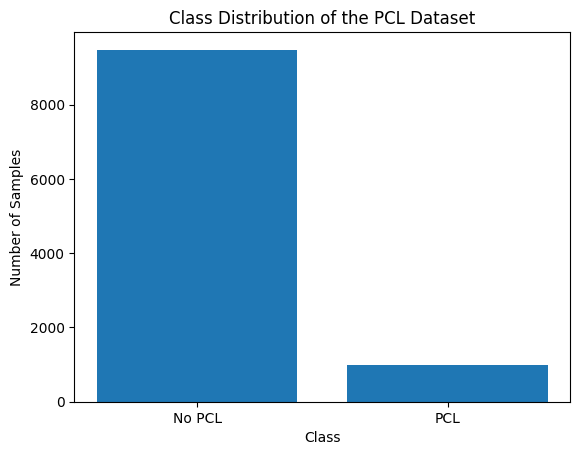

In [22]:
# Class Distribution — Visual Evidence
plt.figure()
plt.bar(class_distribution.index, class_distribution["Count"])
plt.title("Class Distribution of the PCL Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

### Analysis

The dataset exhibits a noticeable class imbalance, with the No PCL class comprising the majority of examples. This indicates that patronising and condescending language is relatively rare compared to neutral reporting. As a result, a naïve classifier that always predicts the majority class could achieve deceptively high accuracy without learning meaningful linguistic patterns.

### Impact Statement

This class imbalance motivates the use of F1-score rather than accuracy as the primary evaluation metric and suggests the need for class weighting or resampling strategies during training. Addressing this imbalance is crucial to ensure the model does not become biased toward predicting the majority No PCL class.

### EDA TECHNIQUE 2
### Lexical Analysis: Word Frequency Analysis by Class

In [23]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text.split()

In [24]:
pcl_texts = df[df["binary_label"] == 1]["text"]
non_pcl_texts = df[df["binary_label"] == 0]["text"]

In [25]:
def get_word_frequencies(texts):
    counter = Counter()
    for text in texts:
        tokens = tokenize(text)
        counter.update(tokens)
    return counter

pcl_freq = get_word_frequencies(pcl_texts)
non_pcl_freq = get_word_frequencies(non_pcl_texts)

In [26]:
top_n = 15

pcl_top = pd.DataFrame(
    pcl_freq.most_common(top_n),
    columns=["Word", "Frequency"]
)

non_pcl_top = pd.DataFrame(
    non_pcl_freq.most_common(top_n),
    columns=["Word", "Frequency"]
)

print("Top words in PCL texts:")
display(pcl_top)

print("Top words in No-PCL texts:")
display(non_pcl_top)

Top words in PCL texts:


,Word,Frequency
0,the,2633
1,to,1648
2,and,1547
3,of,1526
4,in,1077
5,a,1015
6,for,543
7,is,526
8,that,502
9,are,421


Top words in No-PCL texts:


,Word,Frequency
0,the,23218
1,to,12468
2,of,12390
3,and,11272
4,in,9933
5,a,8170
6,for,4347
7,that,4335
8,is,3985
9,on,3015


In [27]:
common_words = set(pcl_freq.keys()).intersection(set(non_pcl_freq.keys()))

diff_data = []
for word in common_words:
    diff_data.append((
        word,
        pcl_freq[word],
        non_pcl_freq[word],
        pcl_freq[word] - non_pcl_freq[word]
    ))

diff_df = pd.DataFrame(
    diff_data,
    columns=["Word", "PCL_Freq", "NoPCL_Freq", "Difference"]
)

diff_df = diff_df.sort_values("Difference", ascending=False).head(10)
diff_df

,Word,PCL_Freq,NoPCL_Freq,Difference
6098,hungry,23,9,14
5019,christmas,29,16,13
3989,compassion,14,4,10
5107,hearts,14,6,8
68,donate,17,10,7
4443,god,36,29,7
2587,darkness,8,2,6
2824,prayer,7,1,6
4553,mercy,12,7,5
795,teresa,6,1,5


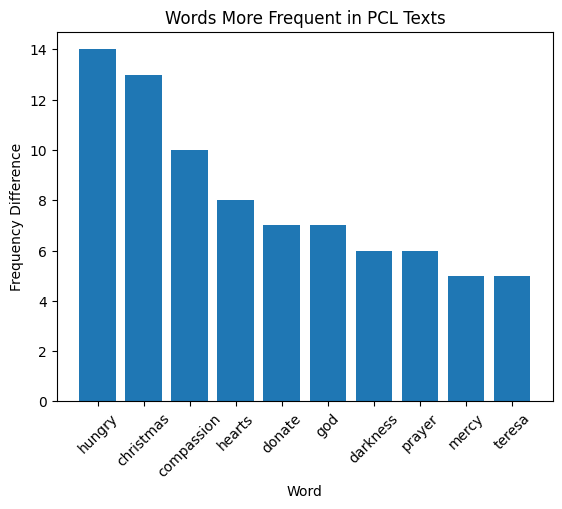

In [28]:
plt.figure()
plt.bar(diff_df["Word"], diff_df["Difference"])
plt.title("Words More Frequent in PCL Texts")
plt.xlabel("Word")
plt.ylabel("Frequency Difference")
plt.xticks(rotation=45)
plt.show()

### Analysis

The most frequent unigrams in both PCL and No-PCL texts are dominated by function words such as “the”, “to”, “and”, and “of”, indicating that surface-level frequency alone is insufficient to distinguish patronising language from neutral reporting. This suggests that PCL detection cannot rely on simple word counts or stylistic differences at the level of stop words.

However, when examining class-skewed lexical items, clearer patterns emerge. Words such as “hungry”, “compassion”, “donate”, “mercy”, “prayer”, and “hearts” appear disproportionately more often in PCL texts. These terms are strongly associated with moral framing, charity, and emotional appeal, which aligns with the definition of patronising and condescending language as portraying vulnerable communities as passive recipients of help. This indicates that PCL is often expressed through sentiment-laden and value-oriented vocabulary, rather than overtly abusive or toxic terms.

### Impact Statement

The dominance of stop words among the most frequent tokens suggests that aggressive stop-word removal alone would not meaningfully separate PCL from No-PCL examples. At the same time, the presence of class-skewed, semantically charged words indicates that simple bag-of-words models may overfit to charity-related keywords rather than learning contextual cues of condescension. As a result, this insight motivates the use of contextualised language models, which can capture how such words are used within broader discourse, and encourages careful regularisation to prevent the model from relying on superficial lexical shortcuts when predicting PCL.